# Sentiment analysis reflections ranking and additional exlorations
The notebook relies on the form of the reflections to be the same as it was when disigned. Otherwise - change accordingly

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
import wordcloud
from wordcloud import WordCloud
import nltk
from pprint import pprint


import os
import re

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


## Get and preprocess the data
This is an example of parsing one week data, for the example of parsing all data see other notebooks

In [71]:
data_folder = r"spring/data" # "." for current folder, or any other path
filename = "CSW8 (S22) Reflection (Week 4) (Responses).xlsx"
# If you are working with csv 
# - just change the filename and make sure no ".xlsx" in it

In [72]:
if ".xlsx" in filename:
    df = pd.read_excel(os.path.join(data_folder, filename))
else:
    df = pd.read_csv(os.path.join(data_folder, filename))
# To make sure that there are no accidential nan's in date. 
# Filling them with string "None", since we treat all the questions as strings here
df.fillna("None", inplace=True)

# Making sure all the columns have string type
df = df.astype(str)

In [73]:
# Let's explore what columns == questions and respondents info we have
pprint(list(df.columns)) # pprint just make our output look nicer

['Timestamp',
 'Email Address',
 'How do you feel about the material this week?',
 'Give a **specific** example/problem that you found difficult this week and '
 'explain _what_ made it challenging. What did you do to solve it? (Write '
 "`None` if this week's material was clear.)",
 'Which zyBooks topic this week did you find to be the easiest?',
 'Which lab session do you attend on Wednesdays?',
 'What does the TA who is leading the lab do (or has done) well?',
 'What can be improved about your lab section? Please be as specific as '
 'possible. Write "Perfect" if nothing can be improved.',
 'During labs, would you like to continue to work in groups or transition to '
 'working individually?',
 'What _specific_ examples/concepts would you like Prof. K to demonstrate '
 'during the class next week? For example, how to check if a dictionary is '
 'empty / how to update an item in the dictionary. (Be as specific as '
 'possible. Write None if all is clear.)',
 'What would make getting h

## General exploration
### What questions have constatnt set of answers?

How do you feel about the material this week?


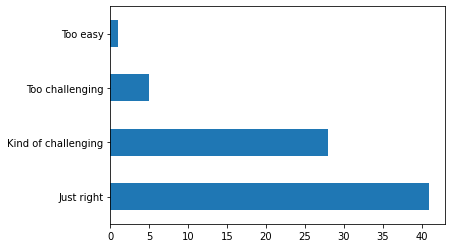

Which lab session do you attend on Wednesdays?


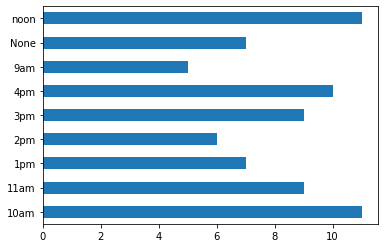

During labs, would you like to continue to work in groups or transition to working individually?


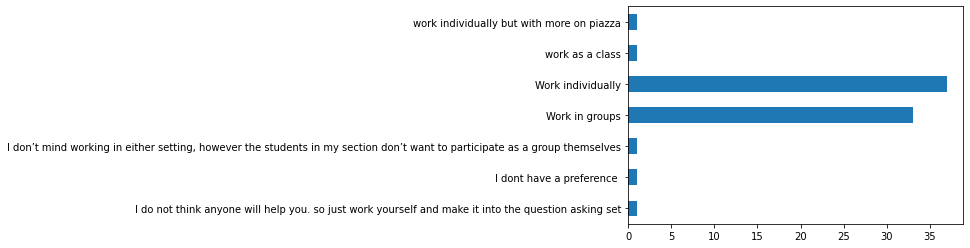

Mental Health Check-in: How are you doing this week (in general, not just in this class)?


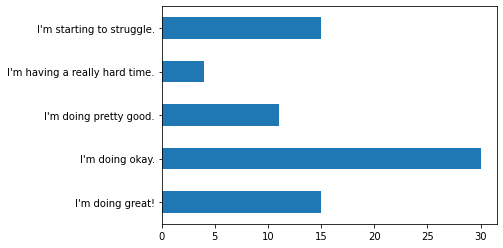

In [74]:
# By going through all of the columns except the index and email
for col in df.columns[2:]:
    # We will count unique answers and have the answers and their number.
    column = df.groupby([col]).size()
    # print(column) # To see what we have unique
    
    # if the total number of unique answers is less than ten
    # - the statistics in bars will look nice
    if len(column) < 10:
        print(col) # get the name of the question we are working with
        ax1 = column.plot.barh()
        y_axis = ax1.axes.get_yaxis()
        y_label = y_axis.get_label()
        y_label.set_visible(False)
        plt.show()

### Let's define some helper functions

In [75]:
from typing import Iterable

def get_lab_nums(answers: Iterable):
    """
    Getting the labs numbers extracted from answers
    :param answers: anything enumerable of strings (e.g. list of strings, pd.series of strings etc)
    :return: The lists sizeof initial answers that contain nothing or all lab numbers
    """
    return [list(re.findall(r'(\d+\.\d+)', x)) # exctract numbers with .
            if isinstance(x, str) # if the parsing object string
            else [str(x)] # if not string - just pass it as is
            for x in answers]

def get_nums(answers: Iterable):
    """
    Getting any numbers extracted from answers
    :param answers: anything enumerable of strings (e.g. list of strings, pd.series of strings etc)
    :return: The lists sizeof initial answers that contain nothing or all lab numbers
    """
    return [list(re.findall(r'(\d+)', x)) 
            if isinstance(x, str) 
            else [str(x)]
            for x in answers]

def clear_all(text: str):
    """
    Remove all the english stop words (except ones in the list that might be important for us) 
    and remove all symbols and return new text
    """
    text = text.lower()
    
    for simb in (".", ",", "!", "?", ";", ":", "(", ")", "\n"):
        text = text.replace(simb, " ")
    text = " " + text + " "
    for word in stopwords.words('english'):
        if word not in ["no","not", "nor", "only"]:
            word = " " + word + " "
            text = text.replace(word, " ")
    
    text = text.replace("   ", " ")
    text = text.replace("  ", " ")
    return text.strip()

def clear_some(text: str, some: list):
    """
    Remove all the words from stoplist "some"
    """
    text = text.lower()
    
    for word in some:
        word = " " + word + " "
        text = text.replace(word, " ")
    
    text = text.replace("   ", " ")
    text = text.replace("  ", " ")
    return text.strip()

def get_n_grams(answers: Iterable, include_one=False, MAX_N_GRAM_SIZE=4):
    """
    Calculate n-grams and their frequensies 
    include_one: True if we want to incluse one-grams
    MAX_N_GRAM_SIZE: how big our biggest n-gram should be
    """
   
    # Build the parsed df
    only_text_answer = pd.DataFrame(answers)
    only_text_answer.columns = ["initial"]
    sample = only_text_answer["initial"][0]
    only_text_answer[only_text_answer["initial"] == None] = ""
    only_text_answer[only_text_answer["initial"].isna()] = ""
    only_text_answer["no_stop"] = only_text_answer["initial"].apply(clear_all)
    only_text_answer["list"] = only_text_answer["no_stop"].apply(lambda x: x.split())
    
    # Calc freq in all answers 
    freq = dict()
    for size in range(1 + int(not include_one), MAX_N_GRAM_SIZE+1):
        for line in only_text_answer["list"]:
            for k in range(len(line)-size):
                if len(line) >= size:
                    key = tuple(line[k:k+size])
                    freq[key] = freq.get(key, 0) + 1
                    
    freq = [(key, val) for key, val in freq.items()]
    return sorted(freq, key=lambda x: x[1], reverse=True)

def get_words_cloud(series: pd.Series, stopwords=None):
    """
    return printable wordcloud based on WorldCloud lib
    excluding or not excluding the stopwords list 
    (manually prepared for reflections by experience)
    stopwords: None for using prerecorded, [] for no stopwords, or custom list
    """
    series = series.apply(str.lower)
    textt = " ".join(series)    
    if stopwords is None:
        stopwords=["none", "nope", "no", "i", "the", "would", "a", "in", "it", "of", "my", "and", "also"]
    wordcloud = WordCloud(
        #The idea here is not to use corpus english stop words, since there are some that is very important for us
        stopwords=stopwords,
        collocation_threshold=4).generate(textt)
    return wordcloud

### Let's find out what labs were the most chalanging

In [76]:
# Change the column name to the one alike from current columns
col =  'Give a **specific** example/problem that you found difficult this week and ' \
            'explain _what_ made it challenging. What did you do to solve it? (Write ' \
            "`None` if this week's material was clear.)"

if col in df:
    # Get the list of lists with lab numbers 
    df["labs"] = get_lab_nums(df[col])
    
    # Caluclate frequesnsies statistics
    all_labs = {}
    for i in df["labs"]:
        for lab in i:
            all_labs[lab] = all_labs.get(lab,0) + 1
    
    print(all_labs)
else:
    print("No such column")

{'4.14': 1, '4.15': 1, '4.17': 1, '4.4': 1, '4.25': 1, '4.13': 1, '4.18': 1, '4.8': 1}


In [77]:
# Change the col to the one of the current columns names from above
col =  'Give a **specific** example/problem that you found difficult this week and ' \
            'explain _what_ made it challenging. What did you do to solve it? (Write ' \
            "`None` if this week's material was clear.)"
top = 5 # print top N
if col in df:
    concepts = get_n_grams(df[col])
    for ind in range(0, top):
        print(" ".join(concepts[ind][0]) + f" : {concepts[ind][1]} times")
else:
    print("No such column")

lab 4 : 5 times
unit test : 4 times
unit tests : 3 times
really hard : 2 times
if/else statements : 2 times


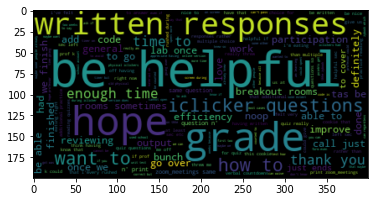

In [78]:
# Fill the colunm name you want to explore
col = 'Last question: any other thoughts or feedback?'

wordcloud = get_words_cloud(df[col])
plt.imshow(wordcloud, interpolation='bilinear')

### Sentiment analysis part

#### First - intial initialization of the model and helper functions

In [56]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv


# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
# labels=[]
# mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
# with urllib.request.urlopen(mapping_link) as f:
#     html = f.read().decode('utf-8').split("\n")
#     csvreader = csv.reader(html, delimiter='\t')
# labels = [row[1] for row in csvreader if len(row) > 1]
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# You can save the model not to load it each time (though it is not very slow)
#model.save_pretrained(MODEL) 

In [57]:
def get_score(text):
    """
    Get scores (neg, neu, pos) for one text
    """  
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

def get_scores(series):
    """
    Get scores (neg, neu, pos) for pandas series of texts
    (WORKS VERY SLOW DUE TO PADDINGS)
    """
    encoded_input = tokenizer(series, return_tensors='pt', padding=True)
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
    scores = softmax(scores, axis=1)
    return scores

def get_scores_for(series):    
    """
    Get scores (neg, neu, pos) for pandas series of texts
    (works faster then just get_scores)
    """
    return [get_score(i) for i in series]

#### Now some applications

In [58]:
# get all scores from roberta model
# Fill the target column name
col = 'Last question: any other thoughts or feedback?'
df["last_santiment"] = get_scores_for([str(i) for i in df[col]])

#See how they came - neg, neu, pos
print("Example", df["last_santiment"].iloc[0])


Example [0.08109468 0.7331774  0.18572792]


#### Apply the additinal rults for sorting

In [64]:

# E.g positive score minus negative (so "how negative the comment are")
df["last_santiment_qua"] = df["last_santiment"].apply(lambda x: x[2] - x[0])

# Filter very short answers
df["last_santiment_qua"] *= (df[col].str.len() > 5)

In [65]:
# Alternative! only negative
#df["last_santiment_qua"] = df["last_santiment"].apply(lambda x: x[0])

In [66]:
# Print interesting ones, sorted by the rule above
for i in df.sort_values(by=['last_santiment_qua'])[col]:
    if len(i) > 5 and "none" not in i.lower() and "nope" not in i.lower():
        print("-", i)

- I really don't like how its been so windy lately.
- I didn't like that the in-class activity lab was made into homework when there wasn't enough time budgeted into the class time to get it done. Also, the iclickers are distracting from taking notes during lecture and add a bunch of unnecessary stress. 
- There are too many quizzes during a week. And I'm a little confused about the grade of these quizzes and the participation of the iclicker. And also, when I finished the quiz last Thursday. I felt like I didn't have enough time to finished them. All of them are very challenging for me.
- I think having the quiz questions be written responses rather than multiple choice for Quiz 3 really threw me off- having written responses in the practice/reading quizzes would be nice to have that additional practice. 
- In most cases, the output of my code is the correct, but I can't pass the unit test, how to avoid it to some extent?
- Thank you for asking me about my mental health. This week has

In [67]:
val = (df["last_santiment_qua"] < 0) # Which means negative greater than positive
print(f"We have {val.sum()}/{len(df)} negative comments")

We have 9/75 negative comments
